## Test Single Cell

In [1]:
from Ionic_current.Ord11 import Ord11_model
from PermanentConstants import Constants
import torch
import math
import time

device = torch.device('cpu')
dtype = torch.float32

In [2]:
const = Constants(
            device=device,
            dtype=dtype,
            Ncell=1,
            nbeats=1,
            dt_factor=1,
            stim_amplitude=20
            )
parameters = const.parameters

In [3]:
ti = 0.0
phi_i = const.phi0.clone()
G_i   = const.g0.clone()
S     = const.S.clone()
state = torch.cat((phi_i, G_i), dim=0)
N = parameters['N']
phi_save  = []
start = time.time()

while ti < const.T:

    if abs(math.fmod(ti, const.parameters['bcl'])) < const.twin:
        dt = const.dt1; dt_samp = const.dt1_samp; Ns = const.Ns1
    else:
        dt = const.dt2; dt_samp = const.dt2_samp; Ns = const.Ns2

   
    if abs(math.fmod(ti, 500)) < 1e-9:
        print(f'time: {ti:.2f} ms')
    parameters['dt'] = dt

    Iion, _, G_new, dX =  Ord11_model(ti, state, parameters, S, device, dtype)

    phi_new = state[0:N] + dt*(-Iion/parameters['Ctot'])
    state[0:N] = phi_new
    state[N:]  = G_new
    if abs(math.fmod(ti, dt_samp)) < 1e-8:
        phi_save.append(phi_new.clone())
    if any(torch.isnan(phi_new)):
        print('NaN detected in membrane potential!')
        break
    ti = round(ti + dt, 5) 
    # ti += dt
end = time.time()
phi_save = torch.stack(phi_save, dim=0)
print(f'Simulation time: {end - start:.2f} seconds')

time: 0.00 ms
Simulation time: 15.73 seconds


Text(0, 0.5, 'Membrane Potential (mV)')

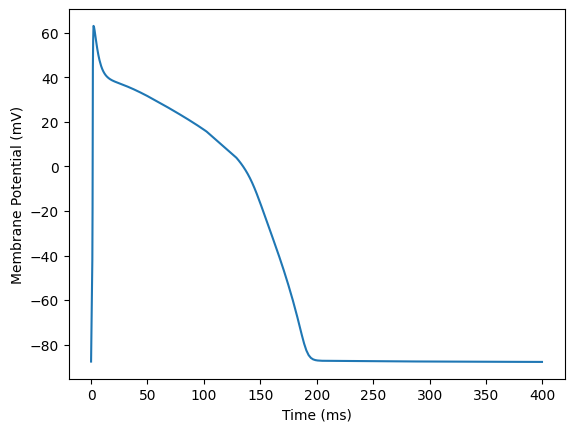

In [4]:
import matplotlib.pyplot as plt
phi_plot = phi_save[:, 0].cpu().numpy()
ts       = const.ts
plt.plot(ts, phi_plot)
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')

## Continuous Cable Equation

The 1D cable equation with ionic current is:

$$
C_m \frac{\partial V}{\partial t}
= D \frac{\partial^2 V}{\partial x^2}
- I_{\text{ion}}(t, x)
$$

### Spatial Discretization

Using a second-order central difference for the Laplacian:

$$
\frac{\partial^2 V}{\partial x^2} \Big|_i
\approx
\frac{V_{i+1}^n - 2V_i^n + V_{i-1}^n}{(\Delta x)^2}
$$

### Explicit Euler Update

$$
V_i^{n+1}
=
V_i^{n}
+
\Delta t
\left[
\frac{D}{C_m (\Delta x)^2}
\left(
V_{i+1}^n - 2V_i^n + V_{i-1}^n
\right)
-
\frac{I_{\text{ion}, i}^n}{C_m}
\right]
$$

### Matrix form

$$\mathbf{V}^n = [v_1^n,v_2^n,\cdots , v_{N-1}^n,v_N^n]^T$$

Consider Neumann B.C.
$$
\mathbf{L}_g = 
\begin{bmatrix}
-1 & 1 & 0 & \dots & 0 \\
1 & -2 & 1 & \dots & 0 \\
0 & 1 & -2 & \dots & 0 \\
\vdots & \vdots & \vdots & \ddots & 1 \\
0 & 0 & 0 & 1 & -1
\end{bmatrix}
$$

Update term,

$$
\mathbf{V}^{n+1} = \underbrace{\left( \mathbf{I} + \Delta t \frac{D}{C_m (\Delta x)^2} \mathbf{L}_g \right) }_{M}\mathbf{V}^n - \Delta t \frac{1}{C_m} \mathbf{I}_{\text{ion}}^n
$$

In [5]:
from Ionic_current.Ord11 import Ord11_model
from PermanentConstants import Constants
import torch
import math
import time

def create_diffusion_mat(N: int, dtype=torch.float32, device=None) -> torch.Tensor:
    if N < 1:
        raise ValueError("N must be at least 1.")

    diag_val = torch.full((N,), -2.0, dtype=dtype, device=device)
    diag_val[0] = -1.0
    diag_val[-1] = -1.0
    
    off_diag_val = torch.full((2 * (N - 1),), 1.0, dtype=dtype, device=device)
    
    indices_i = torch.cat([
        torch.arange(N, device=device),
        torch.arange(N - 1, device=device),
        torch.arange(N - 1, device=device) + 1
    ])
    
    indices_j = torch.cat([
        torch.arange(N, device=device),
        torch.arange(N - 1, device=device) + 1,
        torch.arange(N - 1, device=device)
    ])
    
    indices = torch.stack([indices_i, indices_j])
    values = torch.cat([diag_val, off_diag_val])
    
    return torch.sparse_coo_tensor(indices, values, (N, N), dtype=dtype, device=device)

In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
dtype = torch.float32

const = Constants(
            device=device,
            dtype=dtype,
            Ncell=100,
            nbeats=2,
            dt_factor=1,
            stim_amplitude=5
            )
parameters = const.parameters

D = 1    # Diffusion coefficient (100 μm^2/ms = 1e-3 cm^2/ms)
dx  = 125  # Grid spacing in μm (0.0125 cm)      
Ctot = parameters['Ctot']
Ncell = parameters['Ncell']
ti = 0.0
count = 0
dt = 0.01
phi_i = const.phi0.clone()
G_i   = const.g0.clone()
S     = const.S.clone()
state = torch.cat((phi_i, G_i), dim=0)
N = parameters['N']
phi_save  = []
start = time.time()
T = []

Lg = create_diffusion_mat(Ncell, dtype=dtype, device=device)
M = dt * D / (Ctot * dx**2) * Lg + torch.eye(Ncell, dtype=dtype, device=device).to_sparse()
while ti < const.T:

    # if abs(math.fmod(ti, const.parameters['bcl'])) < const.twin:
    #     dt = const.dt1; dt_samp = const.dt1_samp; Ns = const.Ns1
    # else:
    #     dt = const.dt2; dt_samp = const.dt2_samp; Ns = const.Ns2
    if dt * D / (Ctot * dx**2) > 0.5:
        raise ValueError("Stability condition violated: dt * D / (Ctot * dx^2) must be <= 0.5", dt * D / (Ctot * dx**2))
   
    if abs(math.fmod(ti, 10)) < 1e-8:
        print(f'time: {ti:.2f} ms')
    parameters['dt'] = dt

    Iion, _, G_new, dX =  Ord11_model(ti, state, parameters, S, device, dtype)

    phi_new = M @ state[0:N] + dt*(-Iion/parameters['Ctot'])
    state[0:N] = phi_new
    state[N:]  = G_new
    # phi_i = phi_new.clone()
    if abs(math.fmod(count, 10)) < 1e-8:
        phi_save.append(phi_new.clone())
        T.append(ti)
    
    if count % 1000 == 0:
        if any(torch.isnan(phi_new)):
            print('NaN detected in membrane potential!, time:', ti)
            break
    # ti = round(ti + dt, 5) 
    ti += dt
    count += 1
end = time.time()
phi_save = torch.stack(phi_save, dim=0)

print(f'Simulation time: {end - start:.2f} seconds')

time: 0.00 ms
time: 20.00 ms
time: 30.00 ms
time: 40.00 ms
time: 80.00 ms
time: 90.00 ms
time: 100.00 ms
time: 110.00 ms
time: 120.00 ms
time: 130.00 ms
time: 140.00 ms
time: 150.00 ms
Simulation time: 143.07 seconds


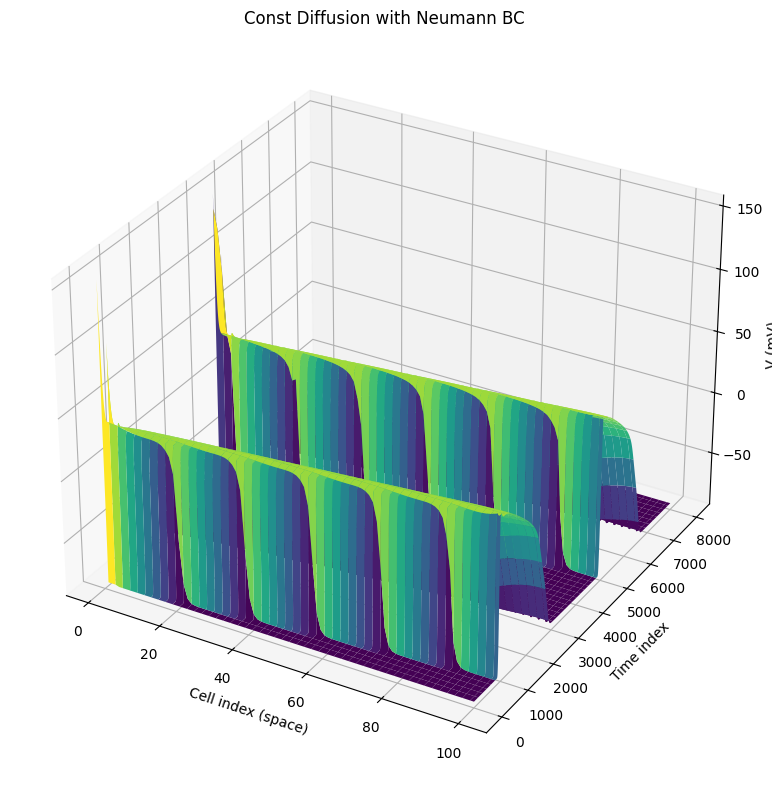

In [7]:
import matplotlib.pyplot as plt
import numpy as np

data_u = phi_save 

m, n = data_u.shape

X, Y = np.meshgrid(np.arange(1, n+1), np.arange(1, m+1))

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, data_u, cmap='viridis', edgecolor='none')

ax.set_xlabel('Cell index (space)')
ax.set_ylabel('Time index')
ax.set_zlabel('V (mV)')
ax.set_title('Const Diffusion with Neumann BC')

plt.tight_layout()
plt.show()


### Test B.C.

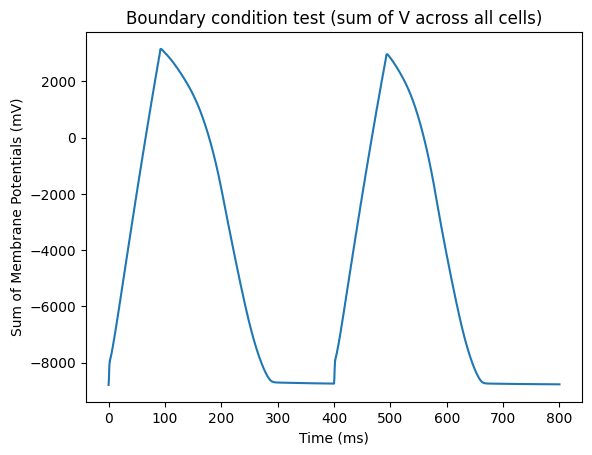

In [8]:
test = data_u.T.sum(axis=0)
t = np.array(T)
plt.plot(t, test)
plt.xlabel('Time (ms)')
plt.ylabel('Sum of Membrane Potentials (mV)')
plt.title('Boundary condition test (sum of V across all cells)')
plt.show()

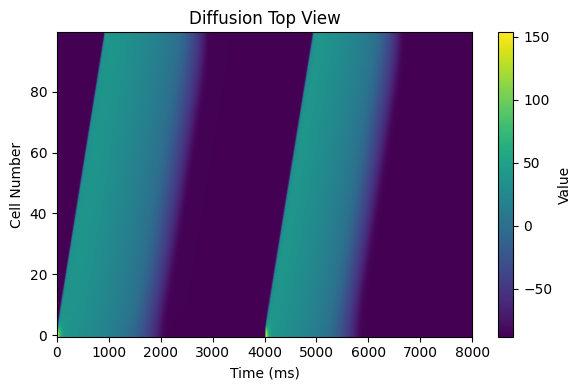

In [14]:
plt.figure(figsize=(6,4))
plt.imshow(data_u.T, 
           aspect='auto', 
           origin='lower',  
           cmap='viridis') 

plt.colorbar(label='Value')
plt.xlabel('Time (ms)')
plt.ylabel('Cell Number')
plt.title('Diffusion Top View')
plt.tight_layout()
plt.show()

### Test ID NN connection

We test with FEM_data1.m with parameters: $d = 5\mu m\,\, d_{ip} = 10 nm\,\, d_{p} = 10nm\,\,A_{f} = 0nm\,\,h_{ip} = 3.2\mu m$

In [10]:
from Ionic_current.Ord11 import Ord11_model
from PermanentConstants import Constants,Normalization
import torch
import math
import time
from model import MLP
import pickle
import torch.nn.functional as F


device = torch.device('cpu')
dtype = torch.float32
GJ_coupling = 'strong'
full_seq = True

if full_seq:
    best_model_state_name = f"Model_state/MLP/best_mlp_{GJ_coupling}_fullseq.pth"
else:
    best_model_state_name = f"Model_state/MLP/best_mlp_{GJ_coupling}_fullseq.pth"

if GJ_coupling == 'strong':
    GJ = 735  # nS
    scaler_name = 'Scaler/strong_standard_scaler.pkl'
else:
    GJ = 73.5 # nS
    scaler_name = 'Scaler/weak_standard_scaler.pkl'

# Load the scaler
with open(scaler_name, 'rb') as f:
    scaler = pickle.load(f)

normalize = Normalization(scaler, device=device, dtype=dtype)
mesh_parameters = torch.tensor(
    [100.0, 0.1, 0.1, 0.0, 32, 735.0],
    device=device,
    dtype=dtype
)  # d, dip, dp, Af, hip, Ggap
hidden_dims = [128, 128, 256, 256, 128]
const = Constants(
            device=device,
            dtype=dtype,
            Ncell=50,
            nbeats=2,
            dt_factor=10,
            stim_amplitude=50
            )
parameters = const.parameters
mesh_parameters = mesh_parameters.unsqueeze(0).repeat(parameters['N'], 1)  # (N, 6)
input_features = 9
output_features = 2
model = MLP(input_features, hidden_dims, output_features,dropout=0.1)
model.load_state_dict(torch.load(best_model_state_name))
model.to(device)
model.eval()

MLP(
  (mlp): Sequential(
    (0): ResidualBlock(
      (net): Sequential(
        (0): Linear(in_features=9, out_features=128, bias=True)
        (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (2): SiLU()
        (3): Dropout(p=0.1, inplace=False)
      )
      (proj): Linear(in_features=9, out_features=128, bias=True)
    )
    (1): ResidualBlock(
      (net): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (2): SiLU()
        (3): Dropout(p=0.1, inplace=False)
      )
    )
    (2): ResidualBlock(
      (net): Sequential(
        (0): Linear(in_features=128, out_features=256, bias=True)
        (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (2): SiLU()
        (3): Dropout(p=0.1, inplace=False)
      )
      (proj): Linear(in_features=128, out_features=256, bias=True)
    )
    (3): ResidualBlock(
      (net): Sequential(
        (0): Linea

## Main simulation forward Euler

In [11]:
ti = 0.0
phi_i     = const.phi0.clone()
G_i       = const.g0.clone()
S         = const.S.clone()
state     = torch.cat((phi_i, G_i), dim=0)
N         = parameters['N']
phi_save  = []
start     = time.time()
Ctot      =parameters['Ctot']
with torch.no_grad():
    while ti < const.T:

        if abs(math.fmod(ti, const.parameters['bcl'])) < const.twin:
            dt = const.dt1; dt_samp = const.dt1_samp; Ns = const.Ns1
        else:
            dt = const.dt2; dt_samp = const.dt2_samp; Ns = const.Ns2

    
        if abs(math.fmod(ti, 100)) < 1e-5:
            print(f'time: {ti:.2f} ms')
        parameters['dt'] = dt

        phi_pad  = torch.cat([phi_i[:1], phi_i, phi_i[-1:]], dim=0) # (N+2,)
        Vf = phi_pad.unfold(dimension=0, size=3, step=1)     # (N, 3)
        out = torch.cat([Vf, mesh_parameters], dim=1)  # (N, 9)
        normalize_out = normalize.normalizeV(out)
        I_cleft = model(normalize_out)  # (N, 2)
        I_cleft = normalize.denormalizeI(I_cleft)
        I_cleft[0,0] = 0.0  # Fix for boundary cell
        I_cleft[-1,-1] = 0.0 # Fix for boundary cell
        I_cleft = I_cleft.sum(dim=1)  # (N,)

        Iion, _, G_new, _ =  Ord11_model(ti, state, parameters, S, device, dtype)
        if torch.isnan(Iion).any():
            print('NaN already in Iion! time:', ti)
            break

        phi_i = state[0:N] -dt/Ctot*(Iion + I_cleft)
        state[0:N] = phi_i
        state[N:]  = G_new
        if abs(math.fmod(ti, dt_samp)) < 1e-8:
            phi_save.append(phi_i.clone())
        if any(torch.isnan(phi_i)):
            print('NaN detected in membrane potential!')
            breakpoint()
            break
        ti = round(ti + dt, 5) 
        # ti += dt
    end = time.time()
    phi_save = torch.stack(phi_save, dim=0)
    print(f'Simulation time: {end - start:.2f} seconds')

time: 0.00 ms
NaN already in Iion! time: 1.589
Simulation time: 4.07 seconds


In [12]:
phi_save.shape

torch.Size([21, 50])

### Single celft model

In [13]:
from Ionic_current.Ord11 import Ord11_model
from PermanentConstants import Constants
import torch
import math
import time

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
dtype = torch.float32

const = Constants(
            device=device,
            dtype=dtype,
            Ncell=100,
            nbeats=2,
            dt_factor=1,
            stim_amplitude=50
            )
parameters = const.parameters

Ggap = parameters['Ggap']*1e-3  # nS     
Ctot = parameters['Ctot']
Ncell = parameters['Ncell']
ti = 0.0
count = 0
dt = 0.01
phi_i = const.phi0.clone()
G_i   = const.g0.clone()
S     = const.S.clone()
state = torch.cat((phi_i, G_i), dim=0)
N = parameters['N']
phi_save  = []
start = time.time()
T = []

while ti < const.T:
   
    if abs(math.fmod(ti, 10)) < 1e-8:
        print(f'time: {ti:.2f} ms')
    parameters['dt'] = dt

    Iion, _, G_new, dX =  Ord11_model(ti, state, parameters, S, device, dtype)

    if torch.isnan(Iion).any():
        print('NaN already in Iion! time:', ti)
        break
    phi_pad  = torch.cat([phi_i[:1], phi_i, phi_i[-1:]], dim=0)
    left  = phi_pad[0:N]       # φ_{i-1}
    mid   = phi_pad[1:N+1]     # φ_i
    right = phi_pad[2:N+2]     # φ_{i+1}

    I_gap = Ggap * ((left - mid) + (right - mid))  # (N,)

    dphi = -(Iion + I_gap) / Ctot
    phi_new = phi_i + dt * dphi
    phi_i = phi_new

    state[0:N] = phi_new
    state[N:]  = G_new

    if count % 10 == 0:
        phi_save.append(phi_new.clone())
        T.append(ti)
    
    if count % 100 == 0:
        if any(torch.isnan(phi_new)):
            print('NaN detected in membrane potential!, time:', ti)
            break
    # ti = round(ti + dt, 5) 
    ti += dt
    count += 1
end = time.time()
phi_save = torch.stack(phi_save, dim=0)

print(f'Simulation time: {end - start:.2f} seconds')

time: 0.00 ms
NaN already in Iion! time: 0.03
Simulation time: 0.01 seconds
